In [1]:
import numpy
from ppe import pressure_poisson

In [2]:
from snippets.ns_helper import cavity_flow, quiver_plot, velocity_term

In [3]:
%matplotlib inline

In [4]:
import pickle

In [5]:
def run_cavity():
    with open('IC.pickle', 'rb') as f:
        u, v, p, b = pickle.load(f)

    nx = 41
    dx = 2 / (nx - 1)
    dt = .005

    nt = 1000
    u, v, p = cavity_flow(u, v, p, nt, dt, dx, 
                          velocity_term, 
                          pressure_poisson, 
                          rtol=1e-4)
    
    return u, v, p

In [6]:
u, v, p = run_cavity()

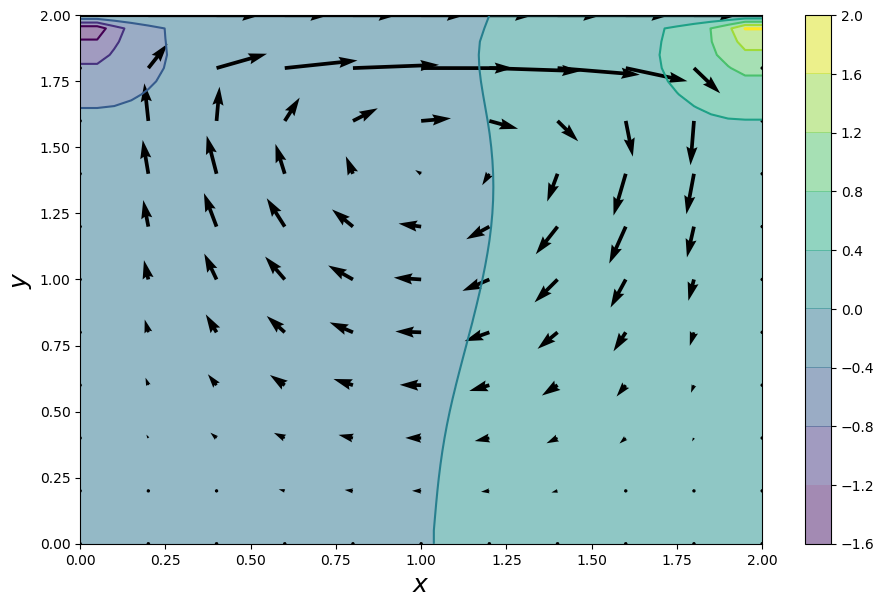

In [7]:
quiver_plot(u, v, p)

In [8]:
'numba' in dir()

False

In [9]:
%timeit run_cavity()

303 ms ± 8.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Installing AoT compiled modules with `setup.py`

In [12]:
# %load ../ppe_compile_module/main.py
import numpy
from math import sqrt
from numba.pycc import CC

cc = CC('ppe')

@cc.export('pressure_poisson',
           'f8[:,:](f8[:,:], f8[:,:], f8)')
def pressure_poisson(p, b, l2_target):
    pn = p.copy()
    I, J = b.shape

    iter_diff = l2_target + 1

    n = 0
    while iter_diff > l2_target and n <= 500:
        pn = p.copy()
        for i in range(1, I - 1):
            for j in range(1, J - 1):
                p[i, j] = (.25 * (pn[i, j + 1] +
                                  pn[i, j - 1] +
                                  pn[i + 1, j] +
                                  pn[i - 1, j]) -
                                  b[i, j])

        for i in range(I):
            p[i, 0] = p[i, 1]
            p[i, -1] = 0

        for j in range(J):
            p[0, j] = p[1, j]
            p[-1, j] = p[-2, j]

        if n % 10 == 0:
            iter_diff = sqrt(numpy.sum((p - pn)**2)/numpy.sum(pn**2))

        n += 1

    return p

cc.compile()


cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++


In [13]:
# %load ../ppe_compile_module/setup.py
#!/usr/bin/env python

from distutils.core import setup
from main import cc

def main():
    """The main entry point."""
    skw = dict(
        name='ppe',
        license='MIT',
        ext_modules=[cc.distutils_extension()],
        )
    setup(**skw)


if __name__ == '__main__':
    main()


ModuleNotFoundError: No module named 'main'